In [1]:
from typing import Tuple, Dict, Callable, Iterator, Union, Optional, List
import os
import sys
import yaml 

import copy

import numpy as np
import torch
from torch import Tensor

# To import module code.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.evaluate import (
    sort_rewards_global_optimization, 
    postprocessing_interpolation_rewards, 
    f_max_new
)

import matplotlib.ticker as ticker

import matplotlib.pyplot as plt

/home/anhtt71/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Objective_Functions():
       
    def evaluate(self, x):        
        n = x.shape[1]
        
        f1 = 1 - torch.exp(-torch.sum((x - 1 / np.sqrt(n))**2, axis = 1))
        f2 = 1 - torch.exp(-torch.sum((x + 1 / np.sqrt(n))**2, axis = 1))
     
        objs = torch.stack([f1,f2]).T
        
        return objs

class Scalar():                                 # Aug Tchebycheff
    def __init__(self):
        self.p = 0.001
        self.e = 0.1
        self.z = torch.Tensor([0.0, 0.0])
        self.weight = torch.Tensor([0.5, 0.5])  # lambda

    def aug_tch(self, f_x):
        tch = torch.max(self.weight * (f_x - (self.z - torch.abs(self.z * self.e))), axis = 1)[0]
        ws = torch.sum(self.weight * f_x, axis = 1)
        
        return (tch + self.p * ws)

def groundtruth(dim):
    obj_func = Objective_Functions()
    scalar = Scalar()
    num_sample = 10000

    x = np.linspace(-1, 1, num_sample)
    x = np.repeat(np.expand_dims(x, axis=1), dim, axis = 1)
    x = torch.from_numpy(x)

    f_x = obj_func.evaluate(x)
    
    g_x = scalar.aug_tch(f_x)
    
    return g_x.squeeze().numpy()

In [3]:
def postprocess_data(configs: List[str], 
                    experiment_path: int,
                    dim: List[int],
                    name: str="",
                    sort_rewards: bool = True,
                    interpolate: bool = True, 
                    max_new: bool = True):

    method_to_name = {'gibo': 'GIBO'}
    
    for cfg_str in configs:

        with open(cfg_str, 'r') as f:
            cfg = yaml.load(f, Loader=yaml.Loader)

        directory = '.'+ cfg['out_dir']
        # print(cfg['out_dir'])

    fx_dict_gibo = {}
    fx_dict_bo = {}
    fx_truth_dict = {}
    x_dict_gibo = {}
    x_dict_bo = {}
    for d in dim:
        x_dict_gibo[d] = np.load(os.path.join(directory, 'x_'+str(d)+ name +'_gibo.npy'), allow_pickle=True)
        x_dict_bo[d] = np.load(os.path.join(directory, 'x_'+str(d)+ name +'_vbo.npy'), allow_pickle=True)
        fx_dict_gibo[d] = np.load(os.path.join(directory, 'fx_'+str(d)+ name +'_gibo.npy'), allow_pickle=True)
        fx_dict_bo[d] = np.load(os.path.join(directory, 'fx_'+str(d)+ name +'_vbo.npy'), allow_pickle=True)
        fx_truth_dict[d] = groundtruth(d)
        
    return x_dict_gibo, x_dict_bo, fx_truth_dict, fx_dict_gibo, fx_dict_bo

In [4]:
def plot_function_value_distances(fx: Dict,
                                fx_truth:Dict,
                                row_col: Tuple[int] = (2, 2)):

    dimensions = list(fx.keys())
    dim_indices = torch.arange(0, len(dimensions))
        
    n_rows, n_cols = row_col
    fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.3)
    axs = np.array(axs).reshape(-1)

    for index_dim, dim in enumerate(dimensions):
        
        if index_dim > n_cols * (n_rows - 1) - 1:
            axs[index_dim].set_xlabel("Iteration", labelpad=10)
        if index_dim in [row * n_cols for row in range(n_rows)]:
            axs[index_dim].set_ylabel("g(x)")
        axs[index_dim].set_title(f"{dim}-dim. domain", fontsize=10)
        num_it = int(len(fx[dim])) -1
        axs[index_dim].set_xlim([0, num_it + num_it/10])
        axs[index_dim].set_xticks([0, num_it/4, num_it/2, num_it*3/4, num_it])
        axs[index_dim].set_ylim([0.3, 0.55])
        axs[index_dim].set_yticks([0.3, 0.35, 0.4, 0.45, 0.5, 0.55])
        
        axs[index_dim].plot(fx[dim], label="g(x)", linestyle="-")
        axs[index_dim].scatter(num_it, np.min(fx_truth[dim]) , label="Global minimal", facecolor ='green')
    
    handles, labels = axs[index_dim].get_legend_handles_labels()

    lgd = fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=n_cols, frameon=False)

######################################################################################################################
def plot_grountruth(fx_truth:Dict,
                    row_col: Tuple[int] = (2, 2)):


    dimensions = list(fx_truth.keys())
    dim_indices = torch.arange(0, len(dimensions))
    
        
    n_rows, n_cols = row_col
    fig2, axs2 = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
    fig2.subplots_adjust(hspace=0.3)
    axs2 = np.array(axs2).reshape(-1)

    for index_dim, dim in enumerate(dimensions):

        if index_dim > n_cols * (n_rows - 1) - 1:
            axs2[index_dim].set_xlabel("x", labelpad=10)
        if index_dim in [row * n_cols for row in range(n_rows)]:
            axs2[index_dim].set_ylabel("g(x)")
        axs2[index_dim].set_title(f"{dim}-dim. domain", fontsize=10)
        n_samples = 10000
        axs2[index_dim].set_xlim([0, n_samples])
        axs2[index_dim].set_xticks([0, n_samples*1/4,n_samples*2/4,n_samples*3/4, n_samples],[-1, -0.5, 0, 0.5, 1])
        axs2[index_dim].set_ylim([0.3, 0.55])
        axs2[index_dim].set_yticks([0.3, 0.35, 0.4, 0.45, 0.5, 0.55])
        
        axs2[index_dim].plot(fx_truth[dim], label="groundtruth", linestyle="dashdot", color ='orange')
        axs2[index_dim].scatter(np.argmin(fx_truth[dim]), np.min(fx_truth[dim]) , label="Global minimal", facecolor ='green')
    
    handles, labels = axs2[index_dim].get_legend_handles_labels()

    lgd = fig2.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=n_cols, frameon=False)

######################################################################################################################
def plot_converge(x_dict_gibo:Dict, x_dict_bo:Dict,
                    row_col: Tuple[int] = (2, 2)):


    dimensions = list(x_dict_gibo.keys())
    
    func = Objective_Functions()
    
    truth = func.evaluate(torch.from_numpy(np.linspace(-1, 1, 101)).unsqueeze(1)).numpy()
    ref_vec = np.array([[0, 0],[truth[50, 0], truth[50, 1]]])
        
    n_rows, n_cols = row_col
    fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.3)
    axs = np.array(axs).reshape(-1)

    for index_dim, dim in enumerate(dimensions):  
        x0 = np.zeros(dim)
        x0[range(0, dim, 2)] = 0.6
        x0[range(1, dim, 2)] = -.3
        x0 = torch.Tensor(x0)
        f_nadir = func.evaluate(x0.unsqueeze(0)).squeeze().numpy()   
        
        x_gibo = torch.from_numpy(x_dict_gibo[dim])
        f_x_gibo = func.evaluate(x_gibo.squeeze()).squeeze().numpy()
        x_bo = torch.from_numpy(x_dict_bo[dim])
        f_x_bo = func.evaluate(x_bo.squeeze()).squeeze().numpy()
        
        axs[index_dim].set_xlabel("f1(x)")
        axs[index_dim].set_ylabel("f2(x)")
        axs[index_dim].set_xlim([0, 1.1])
        axs[index_dim].set_ylim([0, 1.1])
        axs[index_dim].set_title(f"{dim}-dim. domain", fontsize=10)
        axs[index_dim].plot(truth[:, 0], truth[:, 1], color='blue', label="Truth Pareto Front")
        axs[index_dim].plot(ref_vec[:, 0], ref_vec[:, 1], color = 'green', linestyle='--')
        axs[index_dim].scatter(truth[50, 0], truth[50, 1], label="Target", facecolor ='green', marker=(5, 1), s = 100)
        axs[index_dim].plot(f_x_gibo[:, 0], f_x_gibo[:, 1], color='red', linewidth = 3, label="GIBO")
        axs[index_dim].plot(f_x_bo[:, 0], f_x_bo[:, 1], color='purple', linewidth=3, label="Vanilla BayesOpt")
        axs[index_dim].scatter(f_nadir[0], f_nadir[1], facecolor ='orange', s = 30)
        
    
    import matplotlib.patches as mpatches
    
    handles, labels = axs[index_dim].get_legend_handles_labels()

    lgd = fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=n_cols, frameon=False)


### Experiment 1:
+ Dim of x: [2, 5, 10, 20]
+ Learning Rate: 0.005
+ Optimizer: Adam
+ Num Iteration: 500
+ Starting point of x: 
    ```
    x0 = np.zeros(dim)
    x0[range(0, dim, 2)] = 0.6
    x0[range(1, dim, 2)] = -.3
    ```

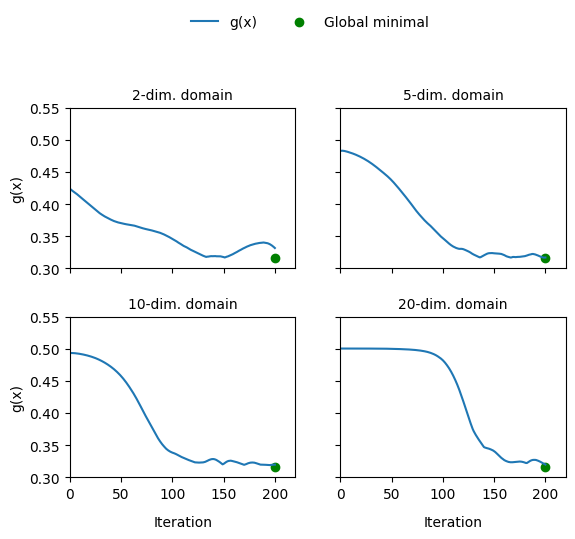

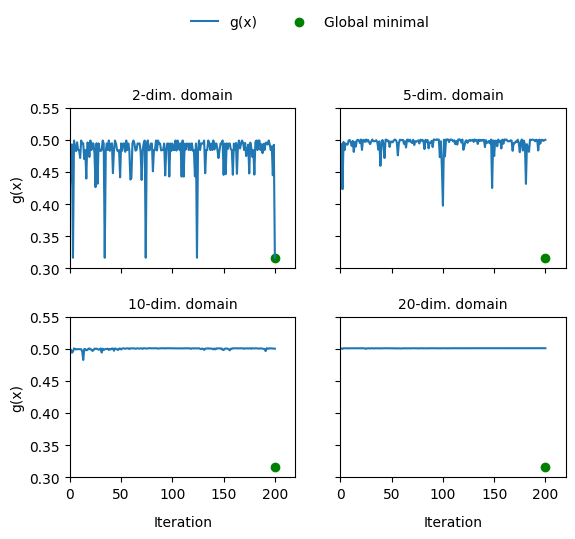

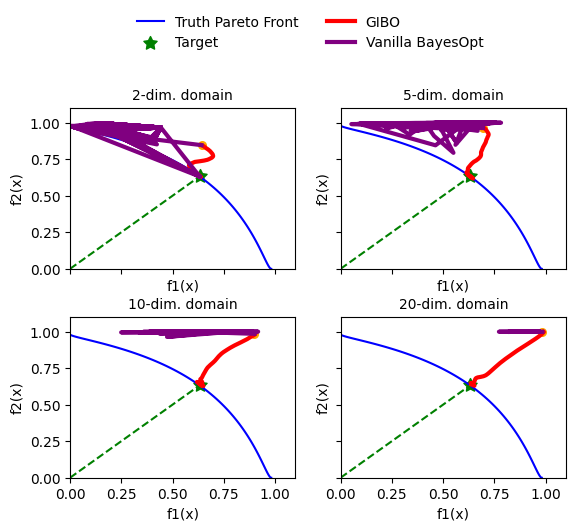

In [5]:
dim = [2, 5, 10, 20]     
(x_dict_gibo, x_dict_bo, fx_truth_dict, fx_dict_gibo, fx_dict_bo) = postprocess_data(
                                configs=['../configs/toys/gibo_default.yaml'],
                                experiment_path='../experiments/toys/test_experiment/', 
                                dim = dim)
          
# plot_grountruth(fx_truth = fx_truth_dict)

plot_function_value_distances(fx=fx_dict_gibo, fx_truth = fx_truth_dict)
plot_function_value_distances(fx=fx_dict_bo, fx_truth = fx_truth_dict)

plot_converge(x_dict_gibo, x_dict_bo, row_col=(2, 2))